In [292]:
import os
import numpy as np
import copy

from IPython.display import display
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.autograd import Variable
from torchvision import models
from PIL import Image
from torchsummary import summary

In [304]:
model = models.resnet18(pretrained=True)

In [305]:
summary(model, (3, 224, 224), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 112, 112]           9,408
       BatchNorm2d-2          [1, 64, 112, 112]             128
              ReLU-3          [1, 64, 112, 112]               0
         MaxPool2d-4            [1, 64, 56, 56]               0
            Conv2d-5            [1, 64, 56, 56]          36,864
       BatchNorm2d-6            [1, 64, 56, 56]             128
              ReLU-7            [1, 64, 56, 56]               0
            Conv2d-8            [1, 64, 56, 56]          36,864
       BatchNorm2d-9            [1, 64, 56, 56]             128
             ReLU-10            [1, 64, 56, 56]               0
       BasicBlock-11            [1, 64, 56, 56]               0
           Conv2d-12            [1, 64, 56, 56]          36,864
      BatchNorm2d-13            [1, 64, 56, 56]             128
             ReLU-14            [1, 64,

In [277]:
def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): Image to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Resize image
    if resize_im:
        pil_im.thumbnail((224, 224))
    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var

In [278]:
def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im

In [279]:
def flatten_model_layers(model):
    res = []
    for module in model.children():
        if isinstance(module, (nn.Sequential)):
            for mod in module.children():
                res += flatten_model_layers(mod)
        else:
            res.append(module)
    return res

In [286]:
def visualize_filter(model, layer_index, filter_index, lr=0.1, iters=50):
    random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
    random_image = preprocess_image(random_image, False)
    
    conv_output = 0
    optimizer = Adam([random_image], lr=lr, weight_decay=1e-6)
    layers = flatten_model_layers(model)
    for i in range(1, iters):
        optimizer.zero_grad()
        # Assign create image to a variable to move forward in the model
        x = random_image
        for index, layer in enumerate(layers):
            # Forward pass layer by layer
            # x is not used after this point because it is only needed to trigger
            # the forward hook function
            x = layer(x)
            # Only need to forward until the selected layer is reached
            if index == layer_index:
                # (forward hook function triggered)
                break

        conv_output = x[0, filter_index]
        # Loss function is the mean of the output of the selected layer/filter
        # We try to minimize the mean of the output of that specific filter
        loss = -torch.mean(conv_output)
        # Backward
        loss.backward()
        # Update image
        optimizer.step()
    
    im = recreate_image(random_image)
    im = Image.fromarray(im)
    return im 

In [312]:
filters = []
for i in tqdm(range(20)):
    img = visualize_filter(model, 3, i, iters=30)
    filters.append(img)

100%|██████████| 20/20 [00:23<00:00,  1.70s/it]


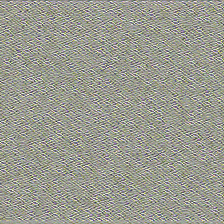

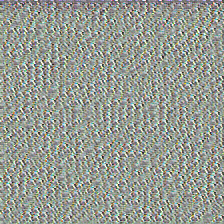

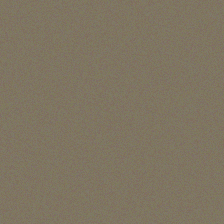

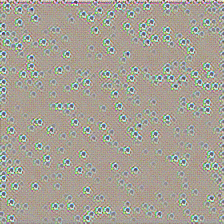

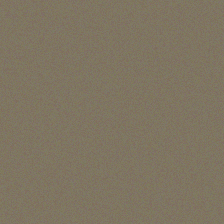

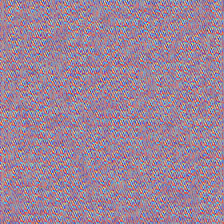

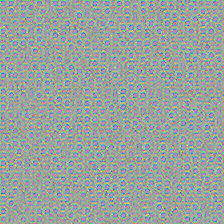

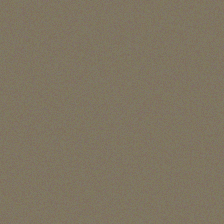

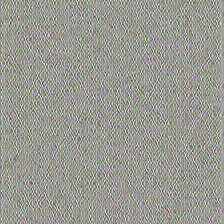

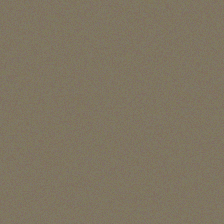

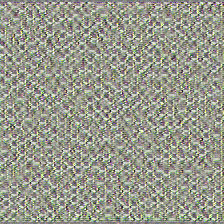

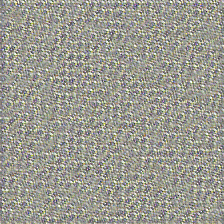

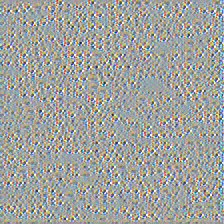

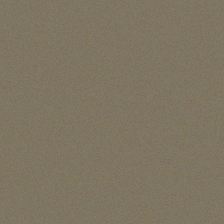

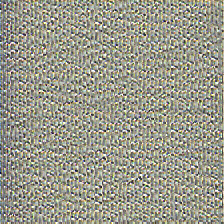

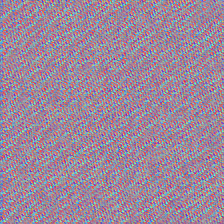

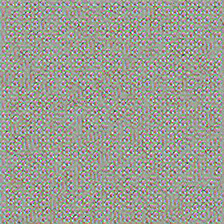

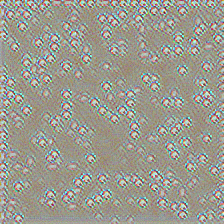

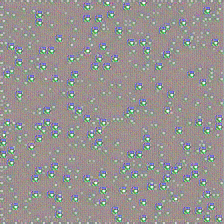

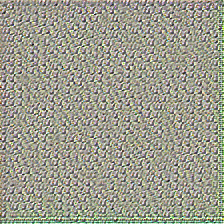

In [313]:
display(*filters)

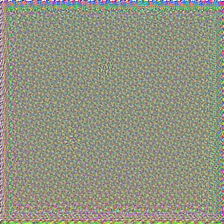

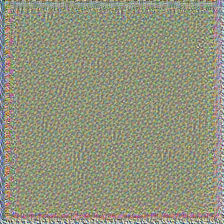

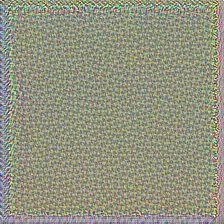

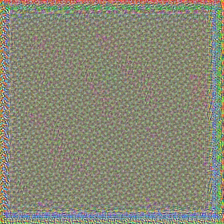

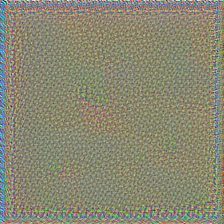

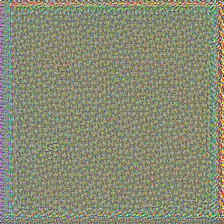

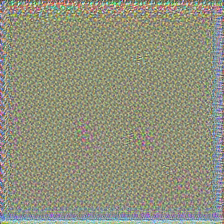

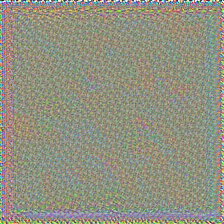

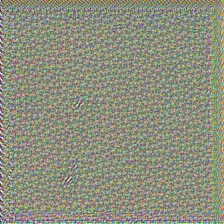

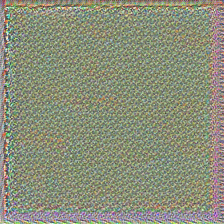

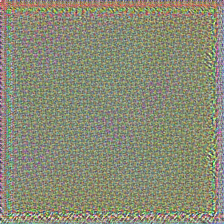

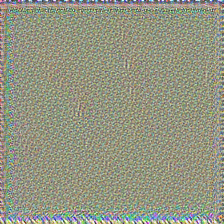

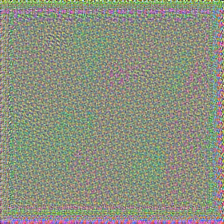

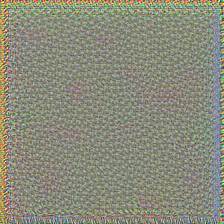

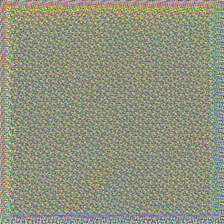

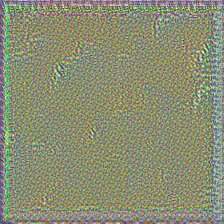

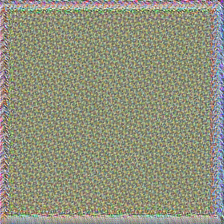

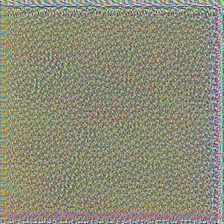

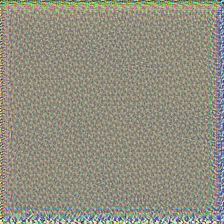

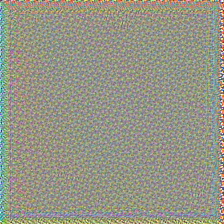

In [302]:
display(*filters)

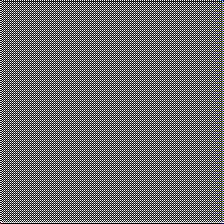

In [282]:
visualize_filter(model, 0, 2)

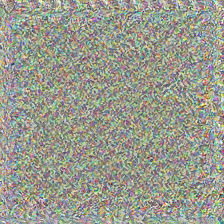

In [285]:
visualize_filter(model, 24, 1, )